# **LSTM - Time Series Dataset**
- 서울특별시 기후 데이터 : 2011년 01월 01일 ~ 2019년 12월 31일
- https://data.kma.go.kr/cmmn/main.do
- 기후통계분석 → 기온분석 → 기간(20110101~20191231) → 검색 → CSV 다운로드
- Seoul_Temp.csv

In [1]:
import warnings
warnings.filterwarnings('ignore')

## **Import Packages**

- Packages

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# **I. Colab File Upload**

> ## **1) 'Seoul_temp.csv' 파일을 Colab에 업로드 후 진행**

In [3]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Seoul_Temp.csv'
temp = pd.read_csv(url)

temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3287 non-null   object 
 1   avg     3287 non-null   float64
 2   min     3287 non-null   float64
 3   max     3287 non-null   float64
dtypes: float64(3), object(1)
memory usage: 102.8+ KB


In [4]:
temp.head()

,date,avg,min,max
0,2011-01-01,-6.8,-10.4,-2.9
1,2011-01-02,-5.4,-8.5,-1.2
2,2011-01-03,-4.5,-8.5,-0.3
3,2011-01-04,-3.9,-7.4,-1.7
4,2011-01-05,-4.0,-7.7,-1.8


# **II. Data Preprocessing**

> ## **1) 일일 평균온도('avg') 변화 시각화**

- 일일 평균온도 변화에 일정한 패턴 확인

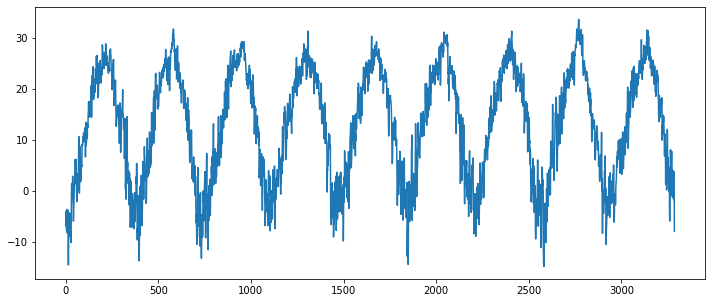

In [5]:
temp_data = temp[['avg']]

plt.figure(figsize=(12, 5))
plt.plot(temp_data)
plt.show()

> ## **2) Normalization**

- tanh Activation 적용을 위해 -1 ~ 1 범위로 정규화

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))

temp_data = scaler.fit_transform(temp_data)

> ## **3) Train vs. Test Split**
- Train_Data_Set : 2011년 01월 01일 ~ 2017년 12월 31일
- Test_Data_Set : 2018년 01월 01일 ~ 2019년 12월 31일

In [7]:
train = temp_data[0:2557]
test  = temp_data[2557:]

# **III. 시계열 데이터 처리 함수**

> ## **1) 시계열 학습용 데이터 생성 함수 정의**
- X : 학습 평균온도 데이터
- y : 정답 평균온도 데이터
- 일정 기간의 X로 y를 예측하도록 학습

In [8]:
def create_dataset(time_data, look_back=1):
  data_X, data_y = [], []

  for i in range(len(time_data) - look_back):
    data_X.append(time_data[i:(i + look_back), 0])
    data_y.append(time_data[i + look_back, 0])
  
  return np.array(data_X), np.array(data_y)

> ## **2) look_back 기간 설정 후 학습 데이터 생성**

- 180일 기간 평균온도로 다음 날 평균온도 예측 데이터 생성

In [9]:
look_back = 180

train_X, train_y = create_dataset(train, look_back)
test_X,  test_y  = create_dataset(test,  look_back)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180), (2377,), (550, 180), (550,))

> ## **3) Tensor Reshape**

In [10]:
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X  = np.reshape(test_X,  (test_X.shape[0],  test_X.shape[1],  1))

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((2377, 180, 1), (2377,), (550, 180, 1), (550,))

# **IV. LSTM Modeling**

> ## **1) Model Define**

In [11]:
model = Sequential(name='LSTM')
model.add(LSTM(64,
               input_shape=(None, 1)))
model.add(Dense(1, activation='tanh'))

- Model Summary

In [12]:
model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


> ## **2) Model Compile**

In [13]:
model.compile(loss='mean_squared_error',
              optimizer='adam')

> ## **3) Model Fit**

- 약 5분

In [14]:
%%time

hist = model.fit(train_X, train_y,
                 epochs=200,
                 batch_size=16,
                 validation_data=(test_X, test_y))

Epoch 1/200
149/149 [==============================] - 4s 11ms/step - loss: 0.0242 - val_loss: 0.0154
Epoch 2/200
149/149 [==============================] - 1s 7ms/step - loss: 0.0161 - val_loss: 0.0138
Epoch 3/200
149/149 [==============================] - 1s 8ms/step - loss: 0.0149 - val_loss: 0.0128
Epoch 4/200
149/149 [==============================] - 1s 7ms/step - loss: 0.0136 - val_loss: 0.0115
Epoch 5/200
149/149 [==============================] - 1s 8ms/step - loss: 0.0124 - val_loss: 0.0105
Epoch 6/200
149/149 [==============================] - 1s 8ms/step - loss: 0.0114 - val_loss: 0.0107
Epoch 7/200
149/149 [==============================] - 1s 7ms/step - loss: 0.0099 - val_loss: 0.0083
Epoch 8/200
149/149 [==============================] - 1s 8ms/step - loss: 0.0093 - val_loss: 0.0082
Epoch 9/200
149/149 [==============================] - 1s 7ms/step - loss: 0.0088 - val_loss: 0.0079
Epoch 10/200
149/149 [==============================] - 1s 7ms/step - loss: 0.0085 - val_l

> ## **4) 학습 결과 시각화**

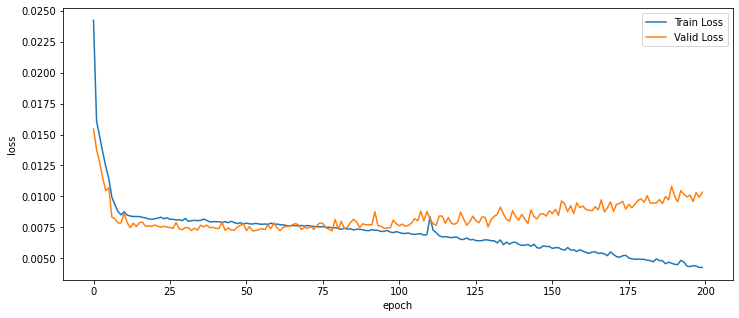

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Valid Loss'], loc='upper right')
plt.show()

> ## **5) Model Evaluate**

In [16]:
trainScore = model.evaluate(train_X, train_y, verbose=0)
print('Train Score :', trainScore)

testScore = model.evaluate(test_X, test_y, verbose=0)
print('Test Score :', testScore)

Train Score : 0.0038653002120554447
Test Score : 0.010342429392039776


# **V. Model Predict**

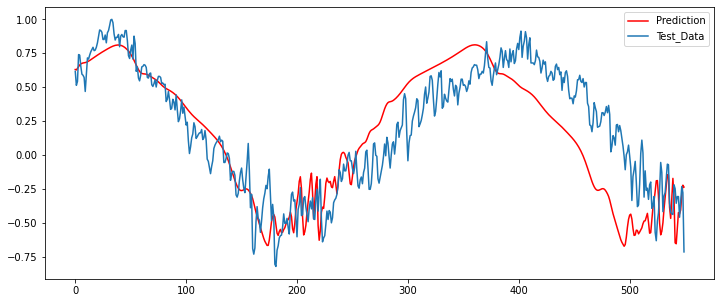

In [17]:
look_ahead = 550

xhat = test_X[0]

predictions = np.zeros((look_ahead, 1))

for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=1)
  predictions[i] = prediction
  xhat = np.vstack([xhat[1:], prediction])   # 배열을 아래로 붙이기

plt.figure(figsize=(12, 5))
plt.plot(np.arange(look_ahead), predictions, 'r', label='Prediction')
plt.plot(np.arange(look_ahead), test_y[:look_ahead], label='Test_Data')
plt.legend()
plt.show()